In [1]:
import calendar
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from descartes import PolygonPatch
from matplotlib.ticker import FormatStrFormatter

import helper_functions.config as config
import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [2]:
# training_data_file = '../training_data_pipeline/data/training_data/1992-2015_california.parquet'
# box_training_data_file = '../training_data_pipeline/data/training_data/1992-2002_california_box.parquet'
# states_shapefile = '../training_data_pipeline/data/spatial_data/cb_2018_us_state_500k.shp'

GRID_SPACING = 0.1

heatmap_contour_levels = 10
heatmap_time_subset = '1997-11-23 18:00:00'

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 5
fig_cols = 3
plot_height = 35
plot_width = 30

plot_locations = [
    (0,0),(0,1),(0,2),
    (1,0),(1,1),(1,2),
    (2,0),(2,1),(2,2),
    (3,0),(3,1),(3,2),
    (4,0),(4,1),(4,2)
]

data_types = [
    'air.2m',      
    'apcp',      
    'crain',      
    'rhum_2m',       
    'dpt_2m',      
    'pres_sfc',      
    'uwnd_10m',      
    'vwnd_10m',      
    'veg',       
    'lcdc',       
    'hcdc',       
    'mcdc',      
    'vis', 
    'lat',
    'lon'
]

plot_titles = [
    'Air Temperature',
    'Accumulated Precipitation',
    'Catagorical Rain',
    'Relative Humidity',
    'Dew Point Temperature',
    'Pressure',
    'East-west Component of Wind',
    'North-south Component of Wind',
    'Vegitation Coverage',
    'Low Height Cloud Coverage',
    'High Height Cloud Coverage',
    'Medium Height Cloud Coverage',
    'Visibility',
    'Latitude',
    'Longitude'
]

weather_variable_labels = [
    'Temp. (K)',
    'Precipitation (in.)',
    'Rain (yes/no)',
    'Humidity (%)',
    'Temp. (K)',
    'Pressure (kPa)',
    'Speed (mph)',
    'Speed (mph)',
    'Coverage (%)',
    'Coverage Fraction',
    'Coverage Fraction',
    'Coverage Fraction',
    'Visibility (meters)',
    'Degrees',
    'Degrees'
]

months = [ 
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]

In [3]:
data = pd.read_parquet(config.raw_data_file)
box_data = pd.read_parquet(config.raw_data_box_file)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28752480 entries, 0 to 28752479
Data columns (total 17 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float32       
 2   lon        float32       
 3   air.2m     float32       
 4   apcp       float32       
 5   crain      float32       
 6   rhum_2m    float32       
 7   dpt_2m     float32       
 8   pres_sfc   float32       
 9   uwnd_10m   float32       
 10  vwnd_10m   float32       
 11  veg        float32       
 12  lcdc       float32       
 13  hcdc       float32       
 14  mcdc       float32       
 15  vis        float32       
 16  ignition   float32       
dtypes: datetime64[ns](1), float32(16)
memory usage: 2.1 GB


In [5]:
# convert Pa to kPa
data['pres_sfc'] = data['pres_sfc'] / 1000

# convert m to km
data['vis'] = data['vis'] / 1000

In [6]:
d = dict(enumerate(calendar.month_abbr))

data['date_time'] = pd.to_datetime(data['date_time'])
data['month'] = data['date_time'].dt.month
data['month'] = data['month'].map(d)
data['year'] = data['date_time'].dt.year

In [7]:
data['ignition'].fillna(0, inplace=True)
box_data['ignition'].fillna(0, inplace=True)

fires_per_bin = box_data.groupby(['lat', 'lon'], as_index=False)['ignition'].sum()

fires_per_month = data.groupby(['month', 'year'], as_index=False)['ignition'].sum()
fires_per_month['ignition'] = fires_per_month['ignition'] / 8

fires_per_year = data.groupby(['year'], as_index=False)['ignition'].sum()
fires_per_year['ignition'] = fires_per_year['ignition'] / 8

In [8]:
california = data_functions.get_california_polygon(config.states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

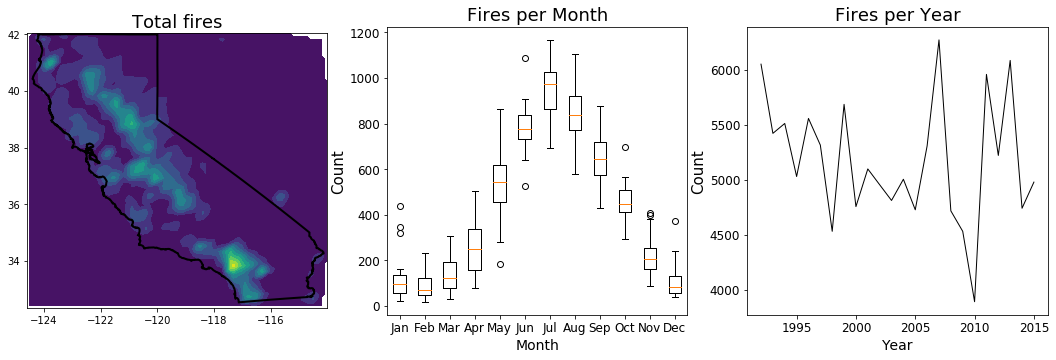

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(27, 5))
fig.subplots_adjust(
    left=left, 
    bottom=bottom, 
    right=right, 
    top=top, 
    wspace=wspace, 
    hspace=hspace
)

x = fires_per_bin['lon']
y = fires_per_bin['lat']
z = fires_per_bin['ignition']

# target grid to interpolate to
xi = np.arange(fires_per_bin['lon'].min(), fires_per_bin['lon'].max(), GRID_SPACING)
yi = np.arange(fires_per_bin['lat'].min(), fires_per_bin['lat'].max(), GRID_SPACING)
xi2, yi2 = np.meshgrid(xi, yi)

# interpolate
zi = griddata((x, y), z, (xi2, yi2), method='linear')

ax[0].add_patch(PolygonPatch(
    california_land_mass, 
    fc='none', ec='black', 
    lw='2', 
    zorder=2
))

ax[0].contourf(xi, yi, zi, heatmap_contour_levels, cmap='viridis')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('Total fires', fontsize=18)

plot_data = [fires_per_month.ignition[fires_per_month['month'] == month].tolist() for month in months]

ax[1].boxplot(plot_data)
ax[1].tick_params(labelsize=12)
ax[1].set_title('Fires per Month', fontsize=18)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Count', fontsize=15)
ax[1].set_xticklabels(months)

ax[2].plot(fires_per_year['year'], fires_per_year['ignition'], color='black', linewidth=1)
ax[2].tick_params(labelsize=12)
ax[2].set_title('Fires per Year', fontsize=18)
ax[2].set_xlabel('Year', fontsize=14)
ax[2].set_ylabel('Count', fontsize=15)

plt.show()

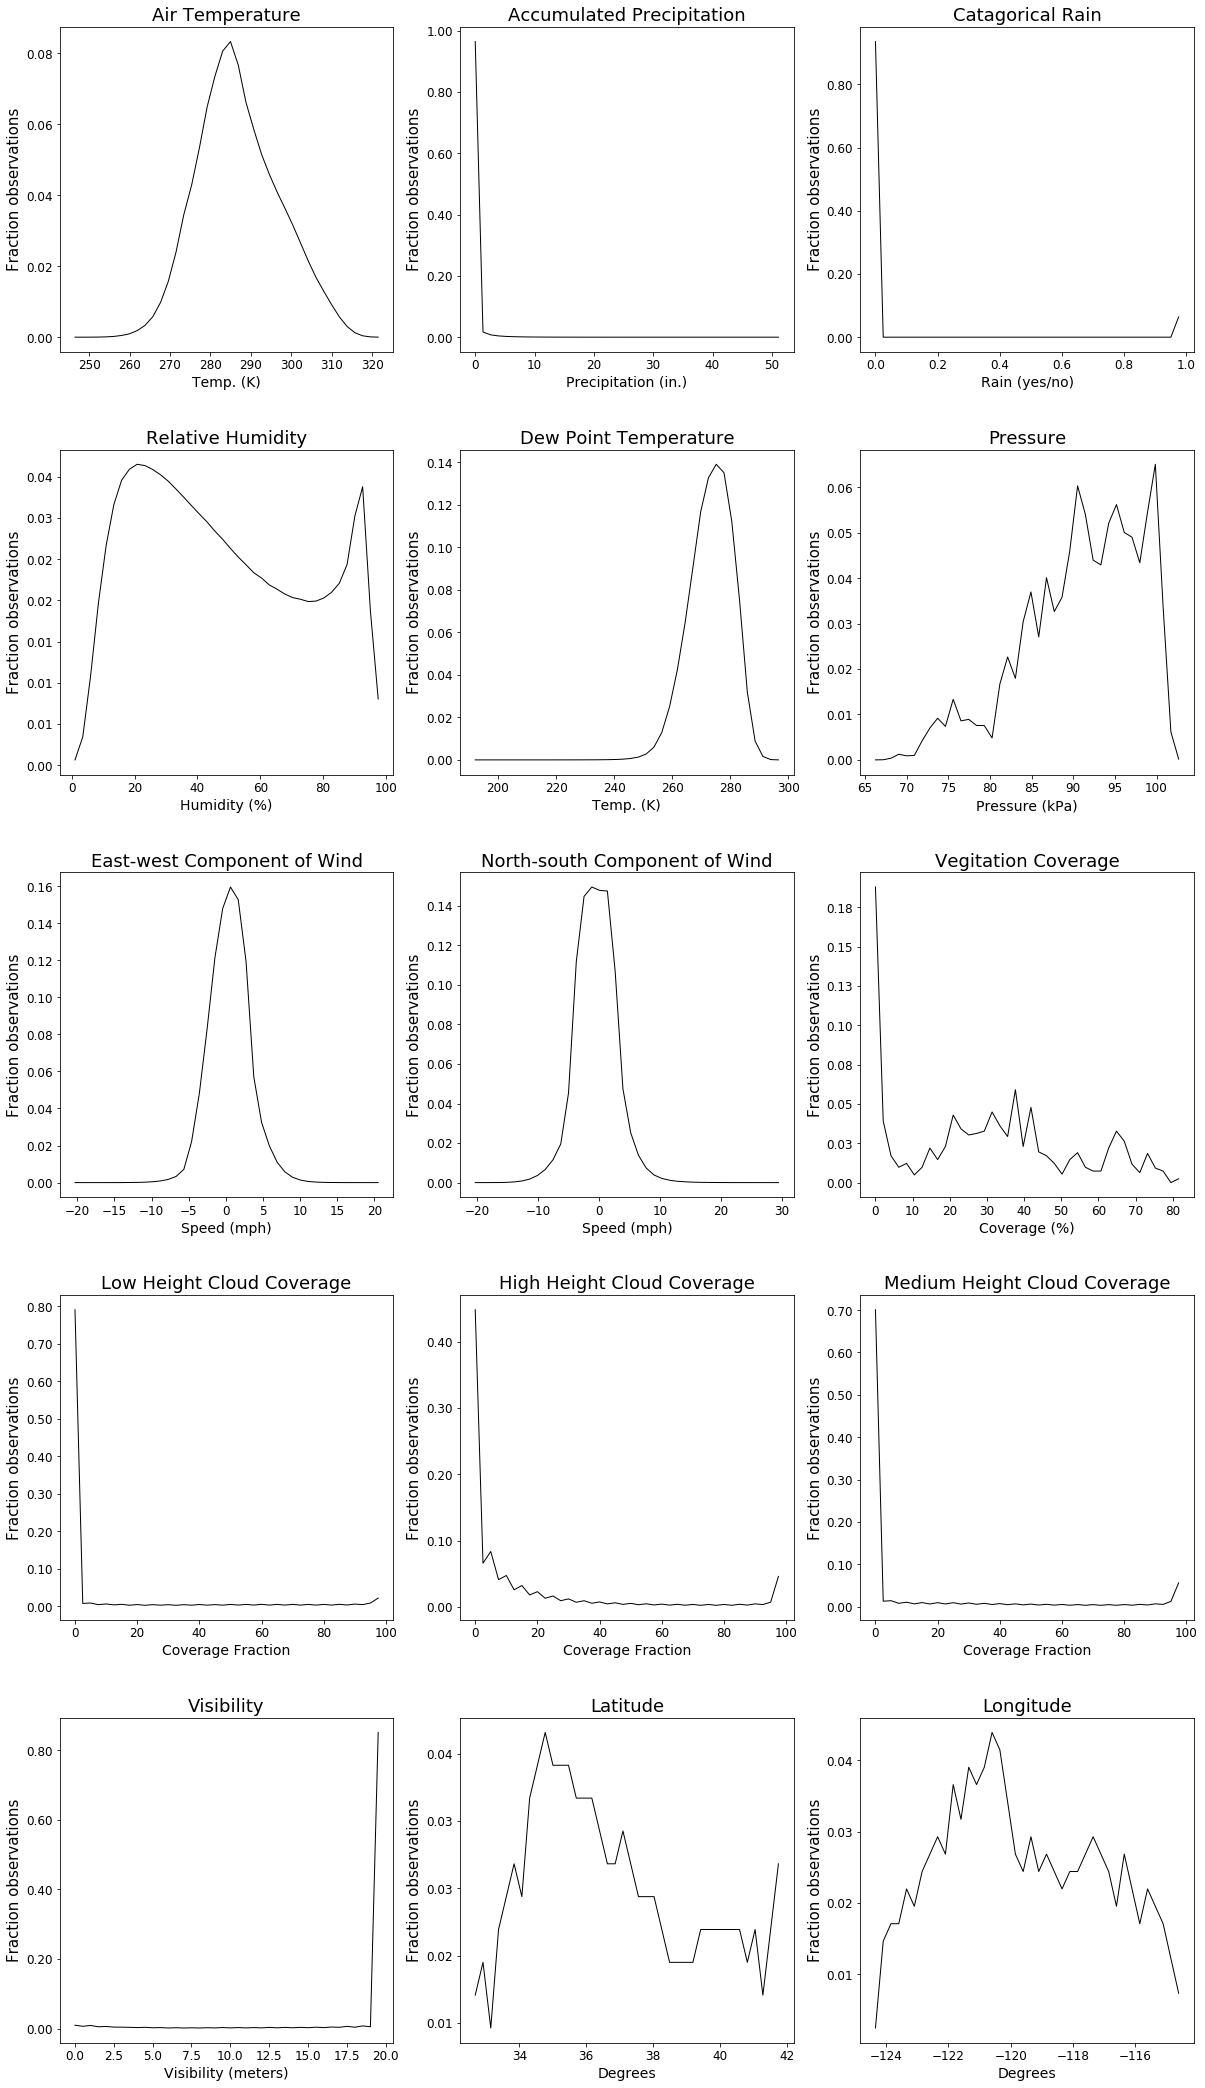

In [10]:
xlabels = weather_variable_labels
ylabels = ['Fraction observations'] * len(xlabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(
    left=left,
    bottom=bottom,
    right=right,
    top=top, 
    wspace=wspace, 
    hspace=hspace
)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = plotting_functions.density_plot(
        ax,
        plot_locations[i], 
        data, 
        data_types[i], 
        plot_titles[i], 
        xlabels[i], 
        ylabels[i]
    )
    
plt.show()

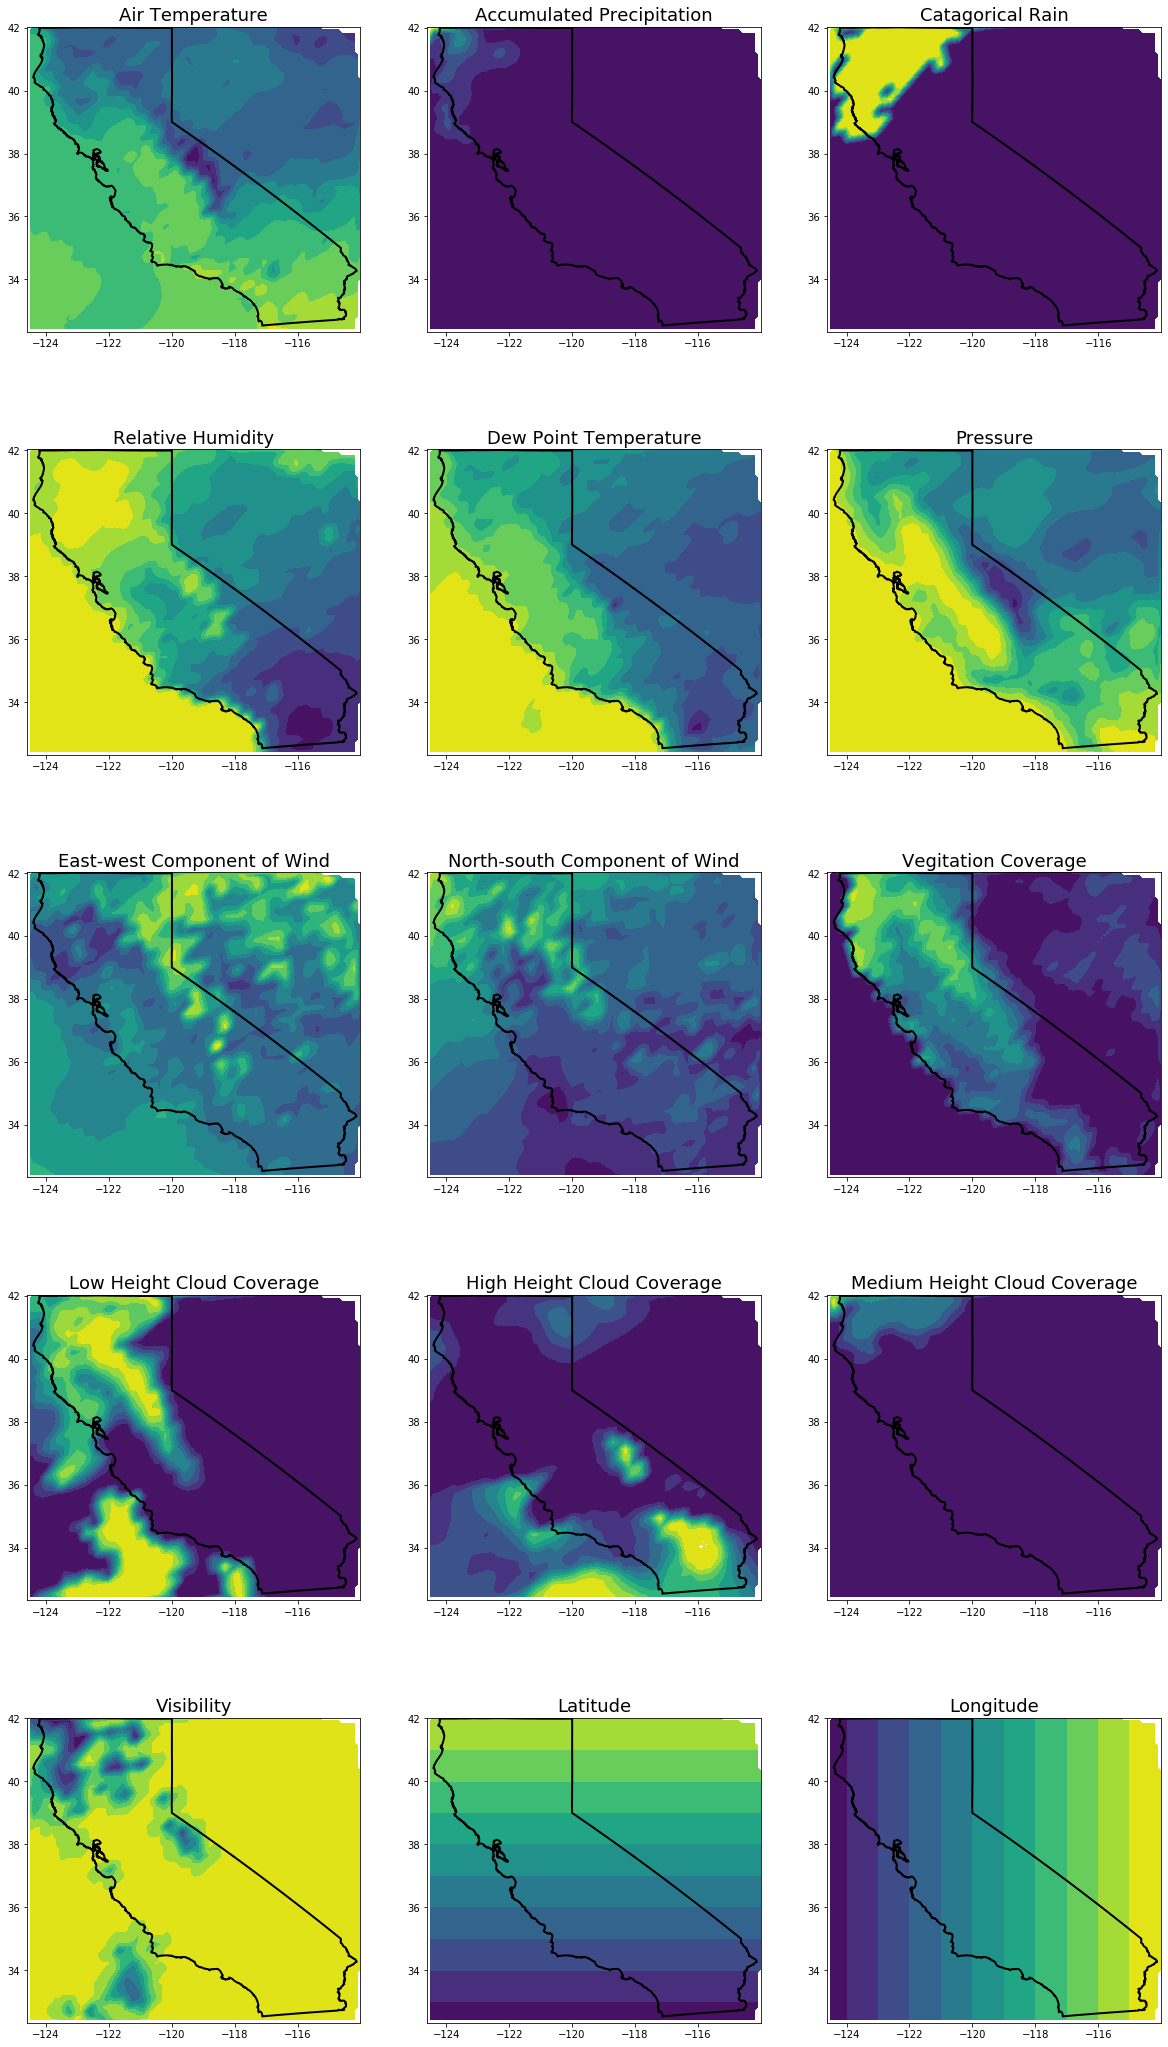

In [11]:
box_data_one_hour = box_data[box_data['date_time'] == heatmap_time_subset]
box_data_one_hour = box_data_one_hour.fillna(0)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    xi, yi, zi = data_functions.regularize_grid(box_data_one_hour, data_types[i], GRID_SPACING)    
    ax[plot_locations[i]] = plotting_functions.map_plot(ax, plot_locations[i], california_land_mass, xi, yi, zi, plot_titles[i], heatmap_contour_levels)

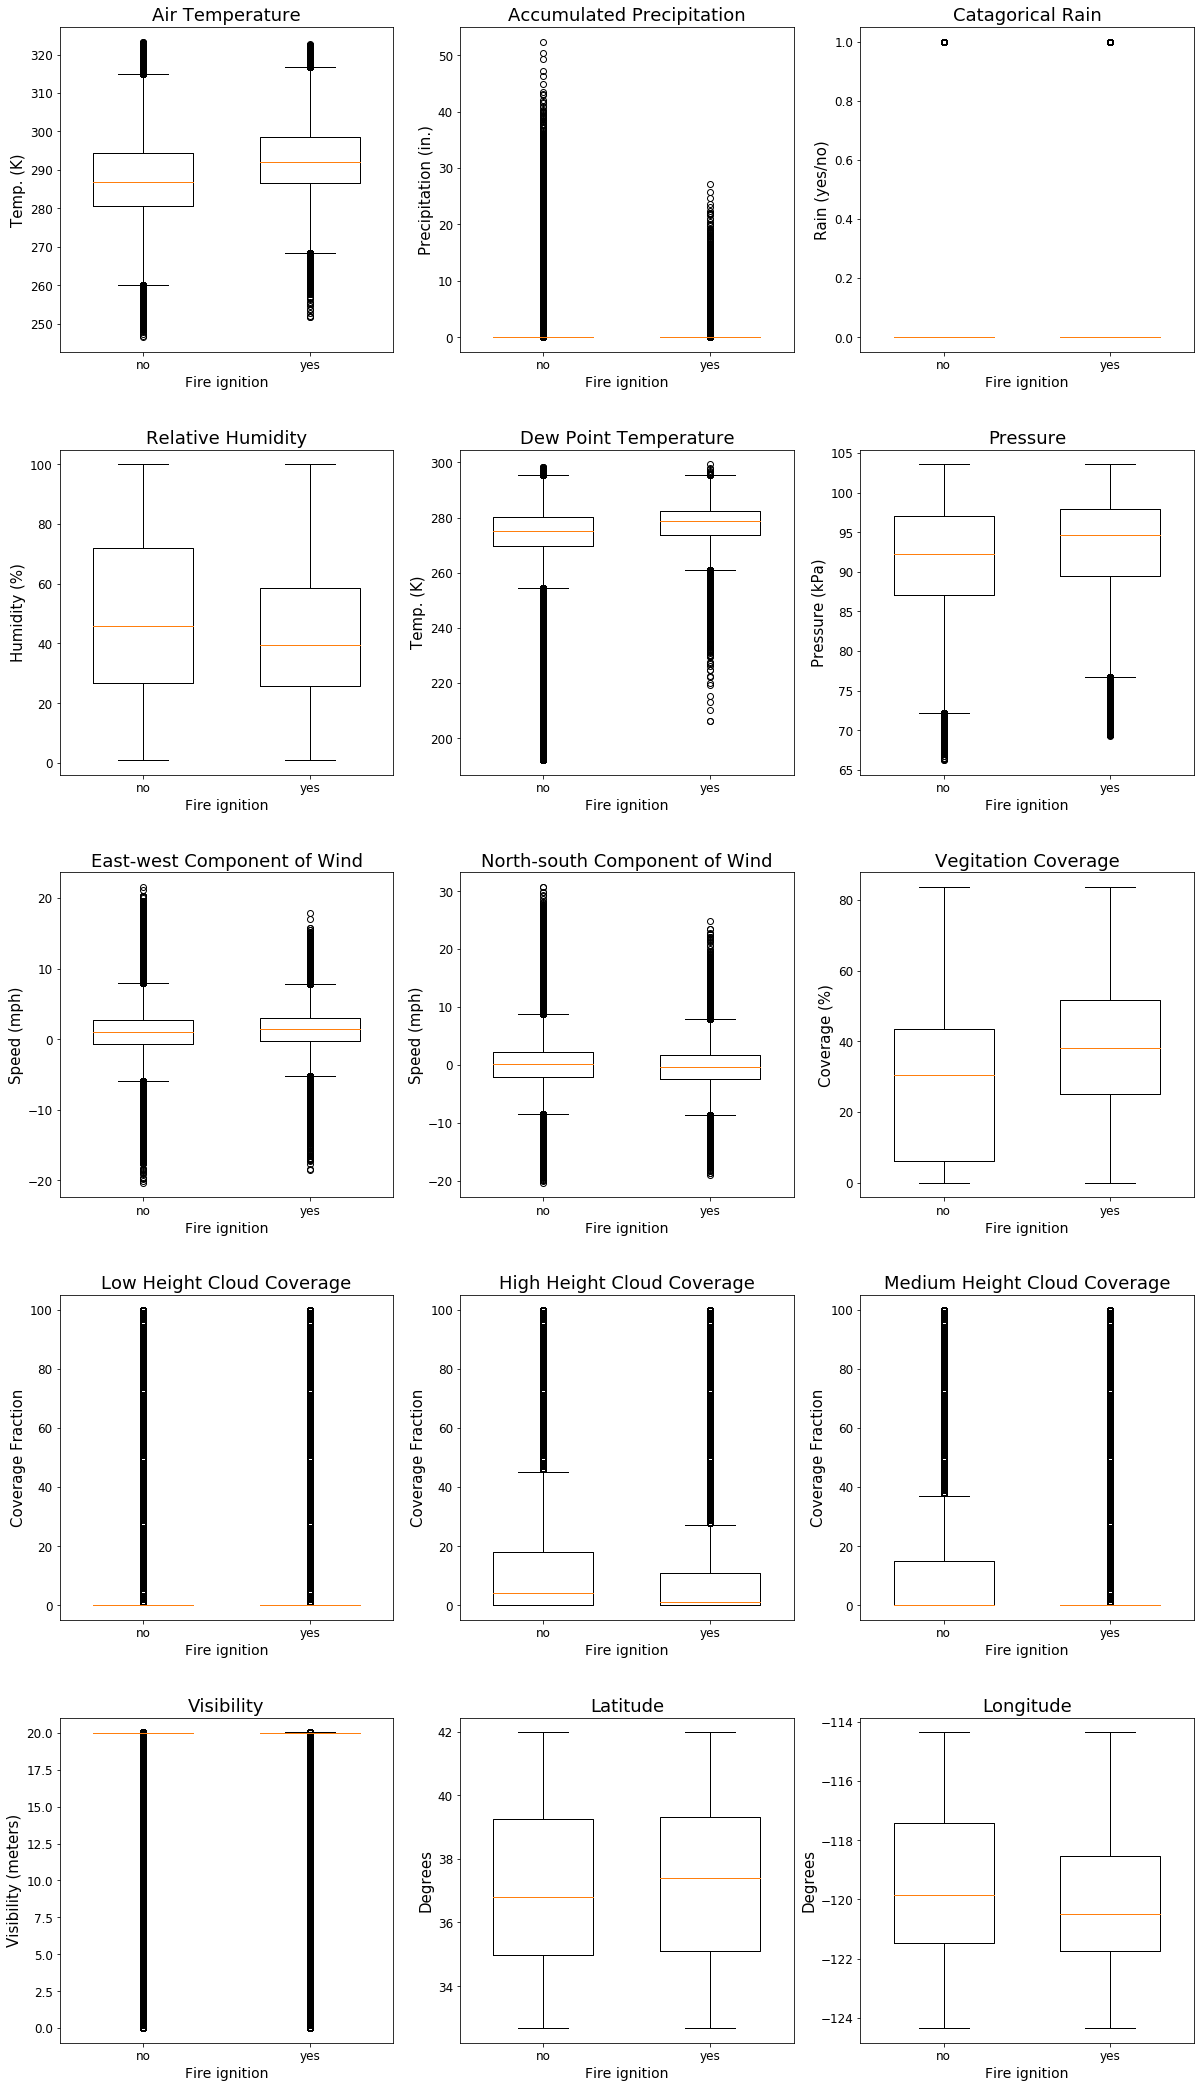

In [12]:
ignition = data[data['ignition'] == 1]
no_ignition = data[data['ignition'] == 0]

ylabels = weather_variable_labels
xlabels = ['Fire ignition'] * len(ylabels)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = plotting_functions.boxplot(ax, plot_locations[i], no_ignition, ignition, data_types[i], plot_titles[i], xlabels[i], ylabels[i])
    
plt.show()

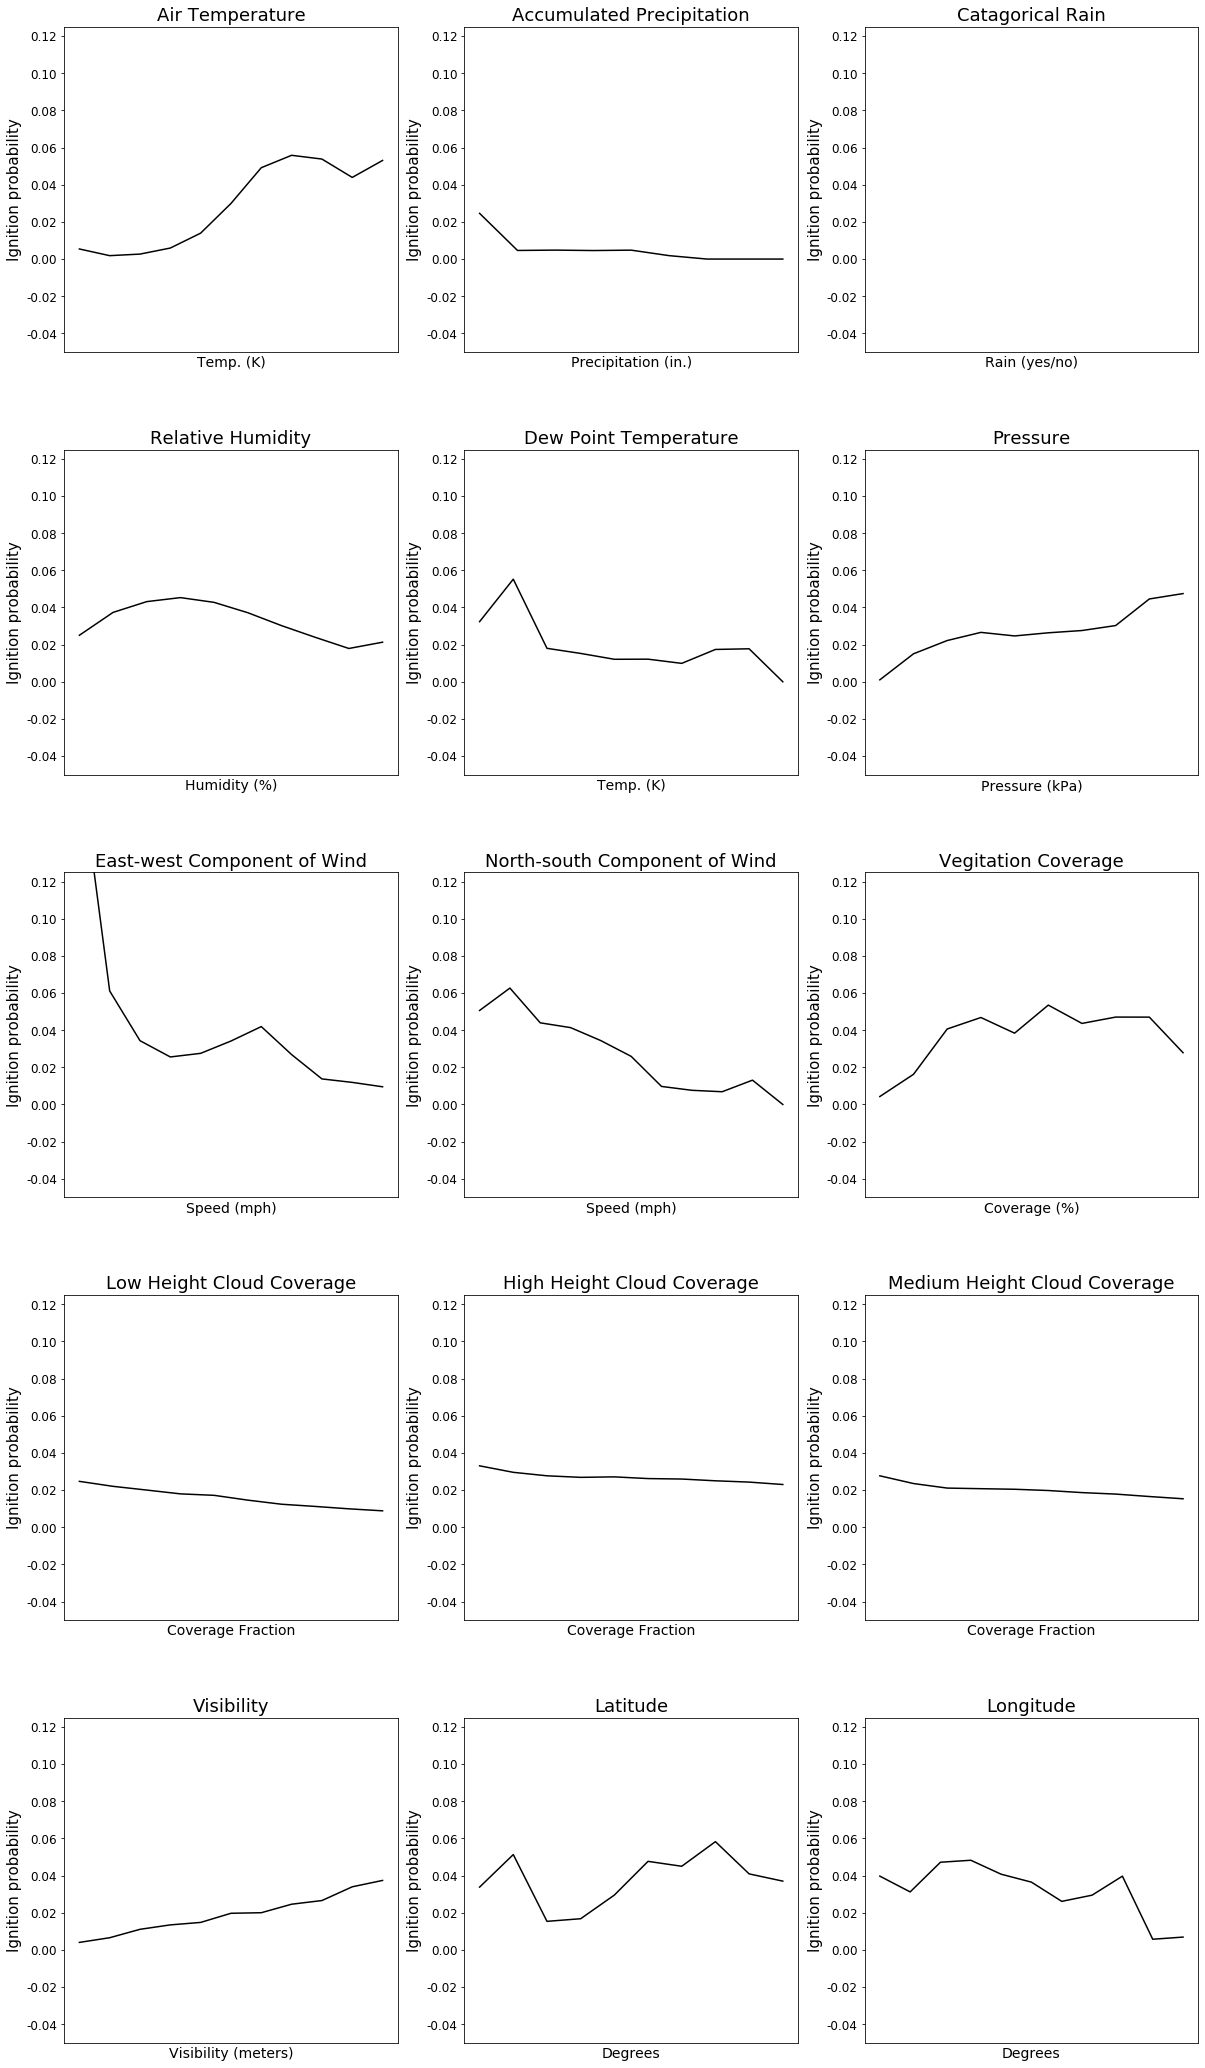

In [13]:
xlabels = weather_variable_labels
ylabels = ['Ignition probability'] * len(xlabels)

num_bins = 11

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = plotting_functions.binned_scatterplot(ax, data, ignition, plot_locations[i], data_types[i], plot_titles[i], xlabels[i], ylabels[i], num_bins)
    
plt.show()

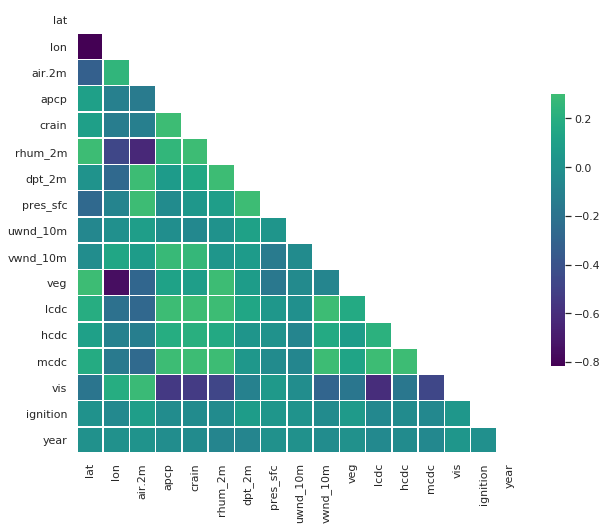

In [14]:
correlation_matrix_all = data.corr()
mask = np.zeros_like(correlation_matrix_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style = "white")
cmap = 'viridis'

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_matrix_all, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()